## Notes on Low-Level Image Processing

You can get a long way in image processing and computer vision with
fairly simple operations that basically just work with arithmetic.
They're not only easier to use than more complex algorithms, but 
also usually faster, easier to inspect, and more reliable than 
complex algorithms. 

It's good to understand low-level techniques if you think you might want 
to use more complex techniques for image recognition or processing, 
including machine learning methods, because complex techniques often 
don't work well without preprocessing by simpler functions. Simple 
functions can also be assembled into quite complex ones.

### Footprint Operations

Many image manipulation techniques rely on looking at each pixel in the 
image, then applying some kind of mathematical function to the pixels 
that fall within some region around it. This region is called a "footprint"
(or sometimes a "kernel"). One of the simplest examples is the _median filter_.
It by replacing each pixel in an image with the median value of the pixels that 
fall within a footprint around it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# NOTE: I don't remember if we opened 'desktop' images before.
from PIL import Image
import scipy.ndimage as ndi

# NOTE: importing custom convenience functions is a little cheaty, but
# removes SO MUCH boilerplate...and teaching the matplotlib API in detail 
# is not the goal of this notebook. We could also publish it somewhere.
# It's trimmed down from moonbow basically

# convenience function for displaying multiple images at once
from ktsutils.mpl import imshow_multiple

# Settings file that removes all the borders and axes and things 
# that aren't really relevant when we're just using matplotlib to
# look at arrays as images.
plt.style.use('settings/simple_image.mplstyle')

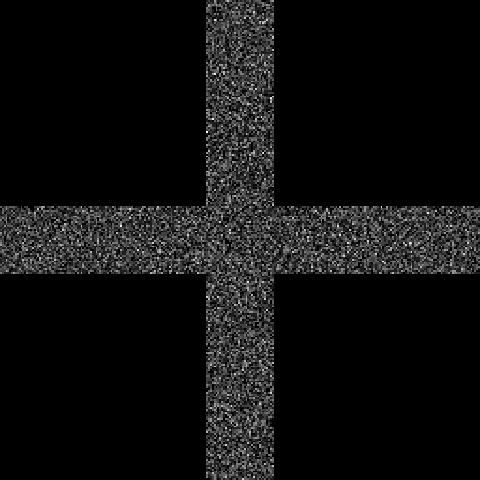

In [2]:
# load in a noisy cross shape.
noisecross = np.asarray(Image.open('images/noisecross.png'))
_ = plt.imshow(noisecross)

In [3]:
# generate big and small footprints. note that what's 'big' and 'small'
# depends on the size of the image you're applying a filter to!
fbig, fsmall = 10, 3
big_foot, small_foot = np.ones((fbig, fbig)), np.ones((fsmall, fsmall))
# these are just arrays:
small_foot

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

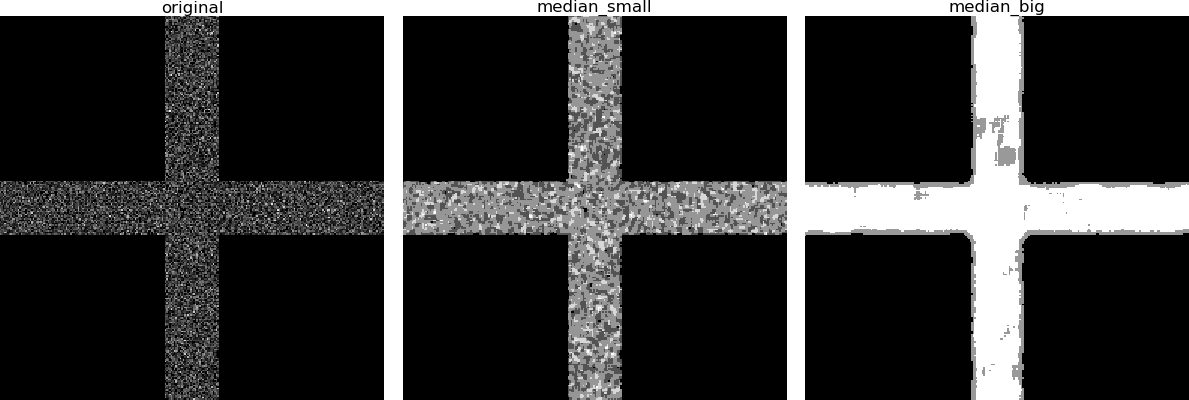

In [4]:
# The median filter has a 'softening' effect. When the footprint is small, the 
# softening is relatively mild; as it gets bigger, the softening gets more intense.
# This is a little bit like turning up the bass on a piece of music: it emphasizes
# more consistent parts of the image and suppresses more variable ones.
nc_small_median = ndi.median_filter(noisecross, footprint=small_foot)
nc_big_median = ndi.median_filter(noisecross, footprint=big_foot)
_ = imshow_multiple(
    [noisecross, nc_small_median, nc_big_median],
    titles = ("original", "median_small", "median_big")
)

In [5]:
# This can be used for many practical purposes. For instance, look 
# at what a median filter can do to the scanlines in this classic Viking Orbiter image
# (a technique the ground team used to great advantage!):
import pdr

viking = pdr.read("/datascratch/viking/edr/vo_1023/f611axx/F611A13.IMG").IMAGE
_ = imshow_multiple(
    [viking, ndi.median_filter(viking, footprint=np.ones((4, 4)))],
    base_figsize=8
)

FileNotFoundError: 

## Morphological Operators

Because subjective fullness of the Moon is basically about shape and line,
we'd like to be able to work directly with those aspects of images. 
Morphological operators are powerful tools for doing this. Morphological
operators are a type of footprint-based filter that use logical operations
like "and" and "or" instead of arithmetic.

### Making Binary Images

Because they do true/false logic, morphological operators want to work on
"binary" images -- black-and-white images made up of only 1s and 0s.

Most images we want to work with don't start out as binary images. The
easiest (and one of the most effective) ways to reduce images to lines
is to set a cutoff value or "threshold". We then set all values below
that threshold to black, and all values above that threshold to white. 
If it's a color image, we also want to turn it to grayscale first.
This often works something like tracing or making an outline of an image --
and these are also good first steps in other processes that want outlines,
like silkscreening.

Let's go ahead and walk through the process.

In [ ]:
# Here is a detail of part of a Tiffany lamp.
tiffany = np.asarray(Image.open("images/tiffany.png"))
_ = plt.imshow(tiffany)

In [ ]:
# Color images are usually 3-D arrays where the third axis
# represents color channel, in this case red (R), green (G) or blue (B).
# This would make a purple version of the image:
purple_tiffany = tiffany.copy()
purple_tiffany[:, :, 1] = 0
_ = plt.imshow(purple_tiffany)

In [ ]:
# The easiest way to make a gray version of a color image is 
# just to merge its channels down, which can be as simple as
# taking their mean or median:
tiffany_gray = np.mean(tiffany, axis=2)
_ = plt.imshow(tiffany_gray)

In [ ]:
# We can now turn it to a black-and-white image with thresholding.
# Picking the correct threshold value is a little bit of an art and
# depends on exactly what features you want the outline to
# retain. Let's see what happens at a few different levels...
threshold_levels = (10, 25, 50, 160)
outlines = [tiffany_gray > level for level in threshold_levels]
_ = imshow_multiple(outlines, titles=threshold_levels, base_figsize=6)

In [ ]:
# Let's try the second one for our outline -- but 
# you might to try the next steps a few times with different
# settings to see what happens.
tiffany_outline = tiffany_gray > 25

### Dilation and Erosion

There are two basic morphological operators: erosion and dilation. Most
other can be assembled from combinations of these two.

Dilation is an "or". If there is a pixel valued 1 anywhere in the dilation 
operator's footprint, it sets the center pixel to 1; otherwise, it sets it
to 0. Erosion is an "and": if _all_ pixels in the erosion operator's 
footprint are 1, it sets the center pixel to 1; otherwise, it sets the
center pixel to 0.

This means that erosion will tend to make black parts of the image heavier,
thicker, and more coherent, and dilation will do the opposite.

Let's look at erosion and dilation here. Note that, just like the median filter 
we saw earlier, bigger footprints tend to make morphological operatorsand selecting the correct footprint size
or shape for particular images and applications can be a very finicky job. "stronger". 

In [ ]:
# Because this particular image is basically a black-on-white outline, erosion 
# will tend to make its lines thicker and its sections more distinct:
sizes = [4, 9]   
eroded = [
    ndi.binary_erosion(tiffany_outline, np.ones((fs, fs)))
    for fs in sizes
]
_ = imshow_multiple(eroded, titles=[f"erosion {s}" for s in sizes])

In [ ]:
# Whereas dilation will tend to make its lines thinner and blur sections:
dilated = [
    ndi.binary_dilation(tiffany_outline, np.ones((fs, fs)))
    for fs in sizes
]
_ = imshow_multiple(dilated, titles=[f"dilation {s}" for s in sizes])

## Labeling

Being able to manipulate lines like this is very useful in part because it
helps us break images up into meaningful pieces. The simplest way to do this is to
simply find matching regions of the image and assign a unique number to 
them. This process is called "labeling", and many good tools for it exist
in Python.

In the next cell, you'll 'thicken' the Tiffany outline and then use `ndi.label()` 
to assign every connected 1-valued region of that outline its own unique number.
It always assigns 0 to what it identifies as "background". 
You'll see that it doesn't work perfectly -- it may cut some sections at the 
edges off, and can't quite distinguish some regions that might look contiguous to 
your eye because of some junky little line bits that connect them.

Like threshold levels, selecting good footprint sizes and shapes for particular images
and applications can be a very finicky job. If you change the footprint size
from (3, 3) and run the cell again, you will see that you get quite different labels.
If you make it a lot bigger, you'll see that you get _fewer_ labels, because the erosion
will have made image areas more distinct from one another...although if you make it big 
enough, you might not get any at all, because you'll have eroded all the lines into one
big line. You'll also get very different results -- probably _much_ larger and more 
connected labels -- if you swap it to binary dilation.

In [ ]:
trace = ndi.binary_erosion(tiffany_outline, np.ones((3, 3)))
labels, n_labels = ndi.label(trace)
print(f"{n_labels} labels found.")
plt.imshow(np.ma.masked_where(labels == 0, labels), cmap='flag', interpolation='none')

We can use this to pick out, count, and locate individual
regions of an image. Try running this next cell a few times to drill
down into the specific image elements our little algorithm identified.
You'll note that not every label is interesting -- `ndi.label()`
will happily assign a unique label to a tiny little dot, as long
as it's isolated. When we look at lunar images a little later, 
we'll need to watch for that fact.

In [ ]:
# Utility functions for visualization.

def apply_2d_stencil(color_image, stencil_2d):
    # reshape `stencil_2d` to fit the 3D color image
    stencil_3d = np.moveaxis(np.tile(stencil_2d, (3, 1, 1)), 0, 2)
    # return a 3D array that contains the original pixels where 
    # `stencil_2d` is truthy, and is black elsewhere
    return np.where(stencil_3d, color_image, 0)

def labelstencil(color_image, label_array, label_numbers):
    """
    Return a copy of `color_image` blacked out wherever the values of 
    `label_array` don't fall within `label_numbers`.
    """
    # make an array that's True for these labels and false otherwise
    return apply_2d_stencil(color_image, np.isin(label_array, label_numbers))


# select 8 random numbers from among all labels, not counting the 
# 0/background label.
random_label_choices = np.random.choice(range(1, n_labels), 8)
fig, ax = plt.subplots(figsize=(5, 7))
ax.imshow(labelstencil(tiffany, labels, random_label_choices))

In [ ]:
# you can also look at just the background:
fig, ax = plt.subplots(figsize=(5, 7))
ax.imshow(labelstencil(tiffany, labels, [0]))

### Getting shapes from labels

Because of image defects and the messy imperfection of the world,
labels don't usually _exactly_ fit the regions you'd like to find
in images, and they also often have very complex boundaries that 
make some kinds of analysis harder (even when the actual objects 
in the scene don't). One straightforward technique that's effective
in many situations is simply to draw some simple geometric shape 
like a circle or rectangle around the label. (Sometimes you're not
looking for simple geometric shapes, of course, in which case this
would not be a good idea.)


OpenCV has several fast, reliable functions for doing this.
Its Python wrapper, `cv2`, is very effective, but its expectations 
are unusual and its error messages aren't always very readable (it's 
practically like a separate language). Rather than spend the rest of 
this Notebook talking about the OpenCV API, we've provided
a couple of example functions in the next cell for performing common 
tasks of this kind with `cv2`.


**DEV NOTE: Again, cheaty. But actually explaining why you have to do all this 
array manipulation and type conversion to use even simple functions from 
the OpenCV API -- and then how each function works, which is weirdly different --
will legitimately take like half a Notebook.**

In [ ]:
from ktsutils.opencv import mask2shape

# and a simple example:
random_label_choices = np.random.choice(range(1, n_labels), 8)
assembled = np.zeros_like(tiffany)
for label in random_label_choices:
    # can also be "circle" or "rectangle"
    _, drawn = mask2shape(labels == label, "triangle", thickness=7)
    assembled += drawn
fig, ax = plt.subplots(figsize=(5, 6))
ax.imshow(
    np.clip(assembled + labelstencil(tiffany, labels, random_label_choices), 0, 255)
)

# SECTIONS SECTIONS SECTIONS

# Moon fullness identification algorithm

## Assumptions

These are not completely true, but good enough for the algorithm:
1. A full Moon looks like a perfect circle.
2. The only things that ever appear in the GOES LUN images are stars, the Moon, the Earth, and static.
3. The Earth will always appear as a contiguous region that touches at least one image edge.
4. If the Moon touches an image edge, we can ignore it, because we won't be able to tell how full
   it is anyway.
5. The images are taken at about the same distance from the Moon, so the Moon will fall within a
   small size range.
6. There are no legitimate images of the Moon at less than half full in this set, so we can
   always assume the Moon label is convex.

## Steps

Given those assumptions, we can perform the following steps to figure out how full
the Moon looks in a GOES image:

1. Load the image.
2. Turn it into a black-and-white "outline" using thresholding.
3. Apply an erosion operator to the outline to clean up static, stars, and imaging imperfections.
4. Label the eroded outline, then exclude labels that are either the wrong size or too close to
   an image edge. If we have exactly one label left after this, it's the Moon; proceed to step 5.
   Otherwise, there's no Moon in the image; stop the algorithm.
6. Apply a dilation operator to smooth the edges of the Moon label, and then 
7. Draw a circle around the label. The ratio of the area of that circle to the that ratio is
   fullness.

## Procedure

First, we'll build the algorithm step by step together -- but this time, we'll be asking _you_ to 
w e  appropriate parameters for the functions. Hints are available, but there's no strict
right answer to this -- different sets of parameters might work equally well, and some might
work better on some images and worse on others.

Then, we'll try the algorithm on all the images and test it against "ground truth". If you don't
like the results you get, then you can go back and tweak your parameters until you do!

### Algorithm step 1: Load the image 

There's not much fancy to do here. The main thing to take note of is that
the filters we're working with do _not_ like masked arrays, but NetCDF4 uses
masks to represent bad values. This wouldn't work in every application, but
in these images, we can get away with just setting every masked element to 0
and throwing the mask away by using the `.filled(fill_value)` method of numpy
masked arrays.

In [ ]:
from netCDF4 import Dataset

def load_goes_image(path):
    array = Dataset(path).variables['radiance'][:]
    return array.filled(0)

### Pick images for pipeline tuning

Go ahead and use this function to load in some test images so
that you can tune the rest of the pipeline effectively.

You probably want to pick at least one that contains a clear image 
of the Moon and one that doesn't. You could even just pick random
ones until you see ones you like -- this is often a good idea for
testing!

In [ ]:
from pathlib import Path
import random
import pandas as pd

LUN_FOLDER = Path("/datascratch/goes_subset_flat/")
goes_lun_index = pd.read_csv("indices/lun_index.csv")

In [ ]:
images, n_images = [], 3
for ix in random.choices(goes_lun_index.index, k=n_images):
    path = LUN_FOLDER / goes_lun_index.loc[ix, 'name']
    images.append(load_goes_image(path))
_ = imshow_multiple(images, base_figsize=9, direction="column")

# Algorithm step 2: Make an outline of the image

This is just like the Tiffany lamp, except these images are already
grayscale, so it's _very_ simple:

In [ ]:
def make_outline(image, threshold):
    return image > threshold

### Tune the threshold value

Find a value for THRESHOLD that produces a sensible result on your
test images. Too low and you'll get too much noise in the outline;
too high and you won't get enough of the Moon (or not reliably, 
depending on exposure time).

As a starting point, remember that the threshold value will want
going to be between the `.min()` and `.max()` of the image,
or it's going to just make the "outline" all white or all black.

In [ ]:
# THRESHOLD = some number

outlines = [make_outline(i, THRESHOLD) for i in images]
# this is a quick way to look at the effects of the function, but in this 
# step as well as later ones, you might also want to stop and examin3
# individual images at larger sizes.
_ = imshow_multiple(outlines, direction="column", base_figsize=7)

# Algorithm step 3: Clean up the image

You'll probably have at least some stars and noise and jaggy scanline stuff 
in your thresholded images, even if they're not immediately obvious (you might
want to look at the images in a bigger form). These can make labeling slower 
and less reliable. This function simply applies a binary erosion operator to 
try to clean these up.

In [ ]:
def erode(image, erosion_size):
    if erosion_size is None:
        return image
    return ndi.binary_erosion(image, np.ones((erosion_size, erosion_size)))

### Start assembling the handler function

Now that we have two steps past the plain loading part, 
we'll want to roll them together so that we can run them all 
at once:

In [ ]:
def fullness_algorithm_3(image, threshold, erosion_size):
    outline = make_outline(image, threshold)
    return erode(outline, erosion_size)

### Tune the erosion operator

Find a good value for `EROSION_SIZE` that cleans some defects without getting
rid of shapes you'd like to keep.

It's often a good idea, when you're designing an algorithm like this, 
to allow yourself to try turning on and off individual steps that _might_ not 
be necessary (things like file loading obviously don't count), so `erode` has 
a provision for turning the step off if you'd like to try that: `EROSION_SIZE=None` 
and move on.

Also keep in mind that all these parameters work together, so you may want to change
your mind about what you set for THRESHOLD as you're working here.

*NOTE: A possible alternative to this step, if you want to play around with the 
algorithm a little more, is to apply a median filter _before_ making the outline.*

In [ ]:
# EROSION_SIZE = some number

processed = [
    fullness_algorithm_3(
        image, threshold=THRESHOLD, erosion_size=EROSION_SIZE
    )
    for image in images
]
# again, you might want to look at these individually at larger size as well.
_ = imshow_multiple(processed, base_figsize=10, direction="column")

### Algorithm step 4: Label the outline and filter out "bad" labels.

Making a label array is easy at this point, but to apply our assumptions that the 
the Moon has a certain minimum extent within the image and that the Moon does not touch 
an image edge, we need to work with the _indices_ of the labels. Let's go ahead and define
a little utility function that produces those along with the label array. (This 
definitely isn't the most efficient way to do it, but it makes it easy to inspect.)

In [ ]:
def indexed_label(arr):
    labels, n_labels = ndi.label(arr)
    label_indices = {}
    for l in range(n_labels + 1):  # we'd like to get 0 as well, just for fun
        # np.nonzero() produces a tuple of ndarrays.
        y_indices, x_indices = np.nonzero(labels == l)
        label_indices[l] = {'y': y_indices, 'x': x_indices}
    return labels, label_indices

#### Create label filters

Now we can iterate over all the labels and look at how big each one is and
where it's positioned.

We can use this to create two filtering functions for the labels: one that
rejects small labels and one that rejects labels close to an image edge.
We'll also have each of these functions output status codes so we know _why_
the pipeline rejects the labels it rejects.

**side notes:**

* The width and height values basically check dimensions of a bounding
non-rotated rectangle for each label, but since we're only concerned with
extent and position at this stage, we don't need to actually _make_ the rectangles.
A more sophisticated version of this algorithm might, though.
* We don't want to construct circles here. One of the things
we're doing by putting a lower limit on both width and height is expressing
ideas like "oh that could definitely not be a circle; it is way too long and
thin." This is a good example of a step where you _shouldn't_ enforce the
shapes you're looking for on labels -- they're not ready for that yet!
* It's inefficient to actually run every set of indices through every
check -- we could stop as soon as a label hit width, or height, or an edge,
etc. We're just doing this because it makes it easier to inspect.

In [ ]:
def filter_label_size(indices, min_width, min_height):
    exclusions = []
    # np.ptp(arr) is shorthand for arr.max() - arr.min()
    if min_width is not None and np.ptp(indices['x']) < min_width:
        exclusions.append('width')
    if min_height is not None and np.ptp(indices['y']) < min_height:
        exclusions.append('height')
    return exclusions

def filter_label_edge(indices, array_shape, edge_size):
    if edge_size is None:
        return []
    exclusions = []
    if (indices['x'] <= edge_size).any():
        exclusions.append('left')
    if (array_shape[1] - indices['x'] <= edge_size).any():
        exclusions.append('right')
    if (indices['y'] <= edge_size).any():
        exclusions.append('top')
    if (array_shape[0] - indices['y'] <= edge_size).any():
        exclusions.append('bottom')
    return exclusions
    
def check_labels(
    label_indices, array_shape, min_width, min_height, edge_size
):
    """
    Handler function that runs filter_label_size() and filter_label_edge()
    on a collection of label indices.
    Returns a dict of lists giving the exclusions each label hit. If
    a label passed all the tests, its list will be empty.
    """
    label_statuses = {}
    for label, indices in label_indices.items():
        label_statuses[label] = (
            filter_label_size(indices, min_width, min_height)
            + filter_label_edge(indices, array_shape, edge_size)
        )
    return label_statuses

#### Add label filters to the handler function

We can put this label-checking step right after the threshold 
and erosion steps. Drawing on our assumption that there will be
at most one Moon in the image, we can also add statements to 
reject an image if it has no ok labels (no Moon in the image, or
something wrong with the algorithm) or more than one ok label 
(something wrong with the algorithm).

Now that we actually might reject an image, we'll also add 
additional information to the function's return value so we can
inspect the algorithm more easily if it's not working well.

In [ ]:
def filter_labels(label_statuses):
    """encapsulates the rule that we must have exactly one Moon in an image."""
    ok_labels = [
        i for i, exclusions in label_statuses.items() if exclusions == []
    ]
    if len(ok_labels) == 0:
        return "no Moon", None
    elif len(ok_labels) > 1:
        return "ambiguous Moon", None
    return "ok", ok_labels[0]

def fullness_algorithm_4(
    image, 
    threshold, 
    erosion_size,
    min_width,
    min_height,
    edge_size
):
    outline = make_outline(image, threshold)
    eroded = erode(outline, erosion_size)
    labels, label_indices = indexed_label(eroded)
    label_statuses = check_labels(
        label_indices, image.shape, min_width, min_height, edge_size
    )
    # 'status' is the overall status of the algorithm.
    # 'moonlabel' is the number of the label the algorithm identified as 
    # corresponding to the Moon, or None if it didn't find the Moon.
    status, moonlabel = filter_labels(label_statuses)
    return {
        "status": status,
        "moonlabel": moonlabel,
        "label_statuses": label_statuses,
        "labels": labels
    }

### Assign exclusion criteria and test Moon identification

Now we can simply assign these exclusion criteria and see
if the algorithm can find the Moon -- and adjust them if it
can't. In order to pick values for `MAX_WIDTH`, `MAX_HEIGHT`,
and `EDGE_SIZE`, you'll probably want to eyeball the pixel extents 
of things in the LUN images. If you want to do that in this
Notebook, you'll want to temporarily turn the default style
back on to get ticks back, like this:
```
with plt.style.context("default"):
    plt.imshow(image)
```
Also, like the erosion value, you can set any of these to 
`None` if you think you might not need them.

As before, you may want to adjust `THRESHOLD` or `EROSION_SIZE`
if you find that the algorithm isn't finding Moon labels well
even if you have good settings for the label filter parameters.

Visualizing individual labels using `labelstencil()`,
`mask2shape()`, or similar may also be useful.

In [ ]:
# MIN_WIDTH = some number
# MIN_HEIGHT = some number
# EDGE_SIZE = some number

results = [
    fullness_algorithm_4(
        image, THRESHOLD, EROSION_SIZE, MIN_WIDTH, MIN_HEIGHT, EDGE_SIZE
    )
    for image in images
]
status_print = '\n'.join([r['status'] for r in results])
print(f"STATUSES\n{status_print}")

### Algorithm step 5: Smooth the label and create a cutout from the image

We'll next take a cutout around the label so that we can work with 
_just_ the part of the source image that contains the Moon. 

Then, before actually comparing the label to a bounding circle, 
we'll want to process it a little. This is because it's likely that 
many labels the algorithm selects, even when they accurately correspond 
to the Moon, will have little holes or jagged edges that will skew 
this comparison low, making the Moon look less illuminated than it really was.
To help counteract this, we'll apply a binary dilation operator to help smooth
and connect the label -- but we don't want to make its footprint too big,
because that can distort the shape too.

We can do this with the functions below.

In [ ]:
def dilate(image, dilation_size):
    if dilation_size is None:
        return image
    return ndi.binary_dilation(image, np.ones((dilation_size, dilation_size)))

def cut_around_indices(image, indices, cutout_margin):
    """
    `indices` should be a single value from the `label_indices` dict
    returned by `indexed_label()` specifying the x/y coordinates occupied
    by a specific label.
    """
    min_x = max(indices['x'].min() - cutout_margin, 0)
    max_x = min(indices['x'].max() + cutout_margin, image.shape[1])
    min_y = max(indices['y'].min() - cutout_margin, 0)
    max_y = min(indices['y'].max() + cutout_margin, image.shape[0])
    cutout = image[min_y:max_y, min_x:max_x]
    # indices of label relative to the cutout
    cutout_indices = {'x': indices['x'] - min_x, 'y': indices['y'] - min_y}
    return cutout, cutout_indices


def make_mask_and_cutout(
    image, moonlabel_indices, dilation_size, cutout_margin
):
    # A cutout from the original image and the indices
    # of the label within that cutout relative to the
    # boundaries of the cutout.
    cutout, cut_indices = cut_around_indices(
        image, moonlabel_indices, cutout_margin
    )
    # A boolean array of the same dimensions as the cutout
    moonmask = np.full(cutout.shape, False)
    # set moonmask to True where the Moon label is present, 
    # False elsewhere.
    moonmask[cut_indices['y'], cut_indices['x']] = True
    return cutout, dilate(moonmask, dilation_size)

### Add dilation and cutout to handler function

As previously, we can just add these to the end of `fullness_algorithm()`,
and include their results in the output dictionary:

In [ ]:
def fullness_algorithm_5(
    image,
    threshold, 
    erosion_size,
    min_width,
    min_height,
    edge_size,
    dilation_size,
    cutout_margin
):
    outline = make_outline(image, threshold)
    eroded = erode(outline, erosion_size)
    labels, label_indices = indexed_label(eroded)
    label_statuses = check_labels(
        label_indices, image.shape, min_width, min_height, edge_size
    )
    # 'status' is the overall status of the algorithm.
    # 'moonlabel' is the number of the label the algorithm identified as 
    # corresponding to the Moon, or None if it didn't find the Moon.
    status, moonlabel = filter_labels(label_statuses)
    output = {
        "status": status,
        "moonlabel": moonlabel,
        "label_statuses": label_statuses,
        "labels": labels
    }
    # We can't continue if we can't identify the Moon.
    if status != "ok":  
        return output
    cutout, moonmask = make_mask_and_cutout(
        image, label_indices[moonlabel], dilation_size, cutout_margin
    )
    return output | {'moonmask': moonmask, 'cutout': cutout}

### Tune cutout margin and dilation size

This is another parameter-tuning task, this time for `DILATION_SIZE` 
and `CUTOUT_MARGIN`. `CUTOUT_MARGIN` is partly a matter of taste -- 
making it too big won't make the algorithm fail, but will make it 
harder to examine the results.

As always, if you don't like what you're seeing here, you may want to go
back and change parameters from earlier steps.

In [ ]:
# DILATION_SIZE = some number
# CUTOUT_MARGIN = some number

results = [
    fullness_algorithm_5(
        image, 
        THRESHOLD, 
        EROSION_SIZE, 
        MIN_WIDTH, 
        MIN_HEIGHT, 
        EDGE_SIZE,
        DILATION_SIZE,
        CUTOUT_MARGIN
    )
    for image in images
]

cutouts = [r['cutout'] for r in results if r['status'] == 'ok']
masks = [r['moonmask'] for r in results if r['status'] == 'ok']
imshow_multiple(cutouts)
_ = imshow_multiple(masks)

## Algorithm step 6: calculate fullness

The next cell completes the `fullness_algorithm()` function by adding circle comparison 
and an option to _not_ return all the label arrays, which will be important for running 
the function on all the images without using up too much memory. 

There aren't any new parameters to tune here: we're just drawing circles, comparing
areas, and looking at the results. 

There aren't any new parameters to tune, but if the results don't look plausible to 
you, go back and change other parameters until they seem at least ok. We'll do 
actual comparison to "ground truth" in the next section.

In [ ]:
def compare_to_circle(mask):
    """
    Draw a bounding circle around a mask made from a label. 
    Compare the area of the mask to the area of that circle.
    Return the computed area ratio, and a representation of 
    that circle drawn on the mask.

    TODO: see if this is notably worse than using the area of
    the hull. Add hull back if so, like:
    hull = cv2.convexHull(mask2vec(mask))
    ratio = cv2.contourArea(hull) / (np.pi * params['r'] ** 2)
    """
    umask = mask.astype("u1") 
    mask_area = umask.sum()
    params, circle = mask2shape(umask, draw_on_array=True)
    return mask_area / (np.pi * params['r'] ** 2), circle


def fullness_algorithm(
    image,
    threshold, 
    erosion_size,
    min_width,
    min_height,
    edge_size,
    dilation_size,
    cutout_margin,
    return_labels = False
):
    outline = make_outline(image, threshold)
    eroded = erode(outline, erosion_size)
    labels, label_indices = indexed_label(eroded)
    label_statuses = check_labels(
        label_indices, image.shape, min_width, min_height, edge_size
    )
    # 'status' is the overall status of the algorithm.
    # 'moonlabel' is the number of the label the algorithm identified as 
    # corresponding to the Moon, or None if it didn't find the Moon.
    status, moonlabel = filter_labels(label_statuses)
    output = {
        "status": status,
        "moonlabel": moonlabel,
        "label_statuses": label_statuses,
    }
    # these will use up a lot of memory.
    if return_labels is True:
        output["labels"] = labels
    # We can't continue if we can't identify the Moon.
    if status != "ok":  
        return output
    cutout, moonmask = make_mask_and_cutout(
        image, label_indices[moonlabel], dilation_size, cutout_margin
    )
    fullness, circle = compare_to_circle(moonmask)
    return output | {
        'moonmask': moonmask, 'cutout': cutout, 'circle': circle, 'fullness': fullness
    }

In [ ]:
# Run the full algorithm and visualize the results.

results = [
    fullness_algorithm(
        image, 
        THRESHOLD, 
        EROSION_SIZE, 
        MIN_WIDTH, 
        MIN_HEIGHT, 
        EDGE_SIZE,
        DILATION_SIZE,
        CUTOUT_MARGIN
    )
    for image in images
]

ok = [r for r in results if r['status'] == 'ok']
ratios = [r['fullness'] for r in ok]
imshow_multiple([r['cutout'] for r in ok])
_ = imshow_multiple(
    [r['circle'] for r in ok], 
    titles=[f"{round(r['fullness'] * 100, 1)}%" for r in ok]
)